# Notebook to show PP plots for the various analyses

### - Import libraries

In [1]:
# Global imports
import sys
import jax
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

# Local imports
import examples_utils as eu
from fastPTA import plotting_functions as sup
from fastPTA.angular_decomposition import spherical_harmonics as sph

print(eu.path_to_file)
%reload_ext autoreload
%autoreload 2
jax.config.update("jax_enable_x64", True)


plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 14,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

cmap = plt.get_cmap("Reds")

/home/pieroni/my_projects/fastPTA_papers/paper_cosmic_variance/fastpta_anisotropies/examples/examples_paper_cosmic_variance/..


### - Define parameters of the analysis to consider

In [4]:
# Maximum multipole for the spherical harmonic decomposition
l_max = 2

# Number of independent pulsar realizations to simulate
n_realizations = 1000

# Number of pulsars per realization
npulsars = 120

# HEALPix resolution parameter
nside = 12

# Number of frequency bins
nfreqs = 15

# Flags to optionally add dipole or quadrupole contributions
add_dipole = False
add_quadrupole = True

# Initialize real spherical harmonic coefficients (size depends on l_max)
clms_real = np.zeros(sph.get_n_coefficients_real(l_max))

# Set the monopole term
clms_real[0] = 1.0

# Optionally add a dipole contribution (l=1)
if add_dipole:
    clms_real[2] = 1.0 / np.sqrt(3)

# Optionally add a quadrupole contribution (l=2)
if add_quadrupole:
    clms_real[6] = np.sqrt(4 * np.pi) / np.sqrt(5 * np.pi)

# Normalize coefficients by sqrt(4π) to ensure proper scaling of the HEALPix map
clms_real /= np.sqrt(4 * np.pi)

### - define file name and load data

In [ ]:
# Base path for saved data files
base = "generated_data/ff_"

# Construct a unique suffix for the filename based on simulation parameters
to_append = (
    str(n_realizations)
    + "_"
    + str(npulsars)
    + "_"
    + str(nside)
    + "_"
    + str(nfreqs)
)

# Prepend dipole/quadrupole labels to the filename and set a human-readable label
if add_dipole:
    to_append = "dipole_" + to_append
    label = "Dipolar injection"

elif add_quadrupole:
    to_append = "quadrupole_" + to_append
    label = "Quadrupolar injection"

else:
    label = "Isotropic injection"

# Load simulation results from the corresponding .npz file
data = np.load(base + to_append + ".npz", allow_pickle=True)

# Extract mean coefficients, standard deviations, and CDFs
clms = data["means"]
dclms = data["stds"]
cdfs = data["cdfs"]

# Remove any rows where mean coefficients contain NaNs
cdfs = cdfs[~np.isnan(clms).any(axis=1)]
dclms = dclms[~np.isnan(clms).any(axis=1)]
clms = clms[~np.isnan(clms).any(axis=1)]

# Remove any rows where standard deviations contain NaNs
cdfs = cdfs[~np.isnan(dclms).any(axis=1)]
clms = clms[~np.isnan(dclms).any(axis=1)]
dclms = dclms[~np.isnan(dclms).any(axis=1)]

### - Plot 1d posteriors

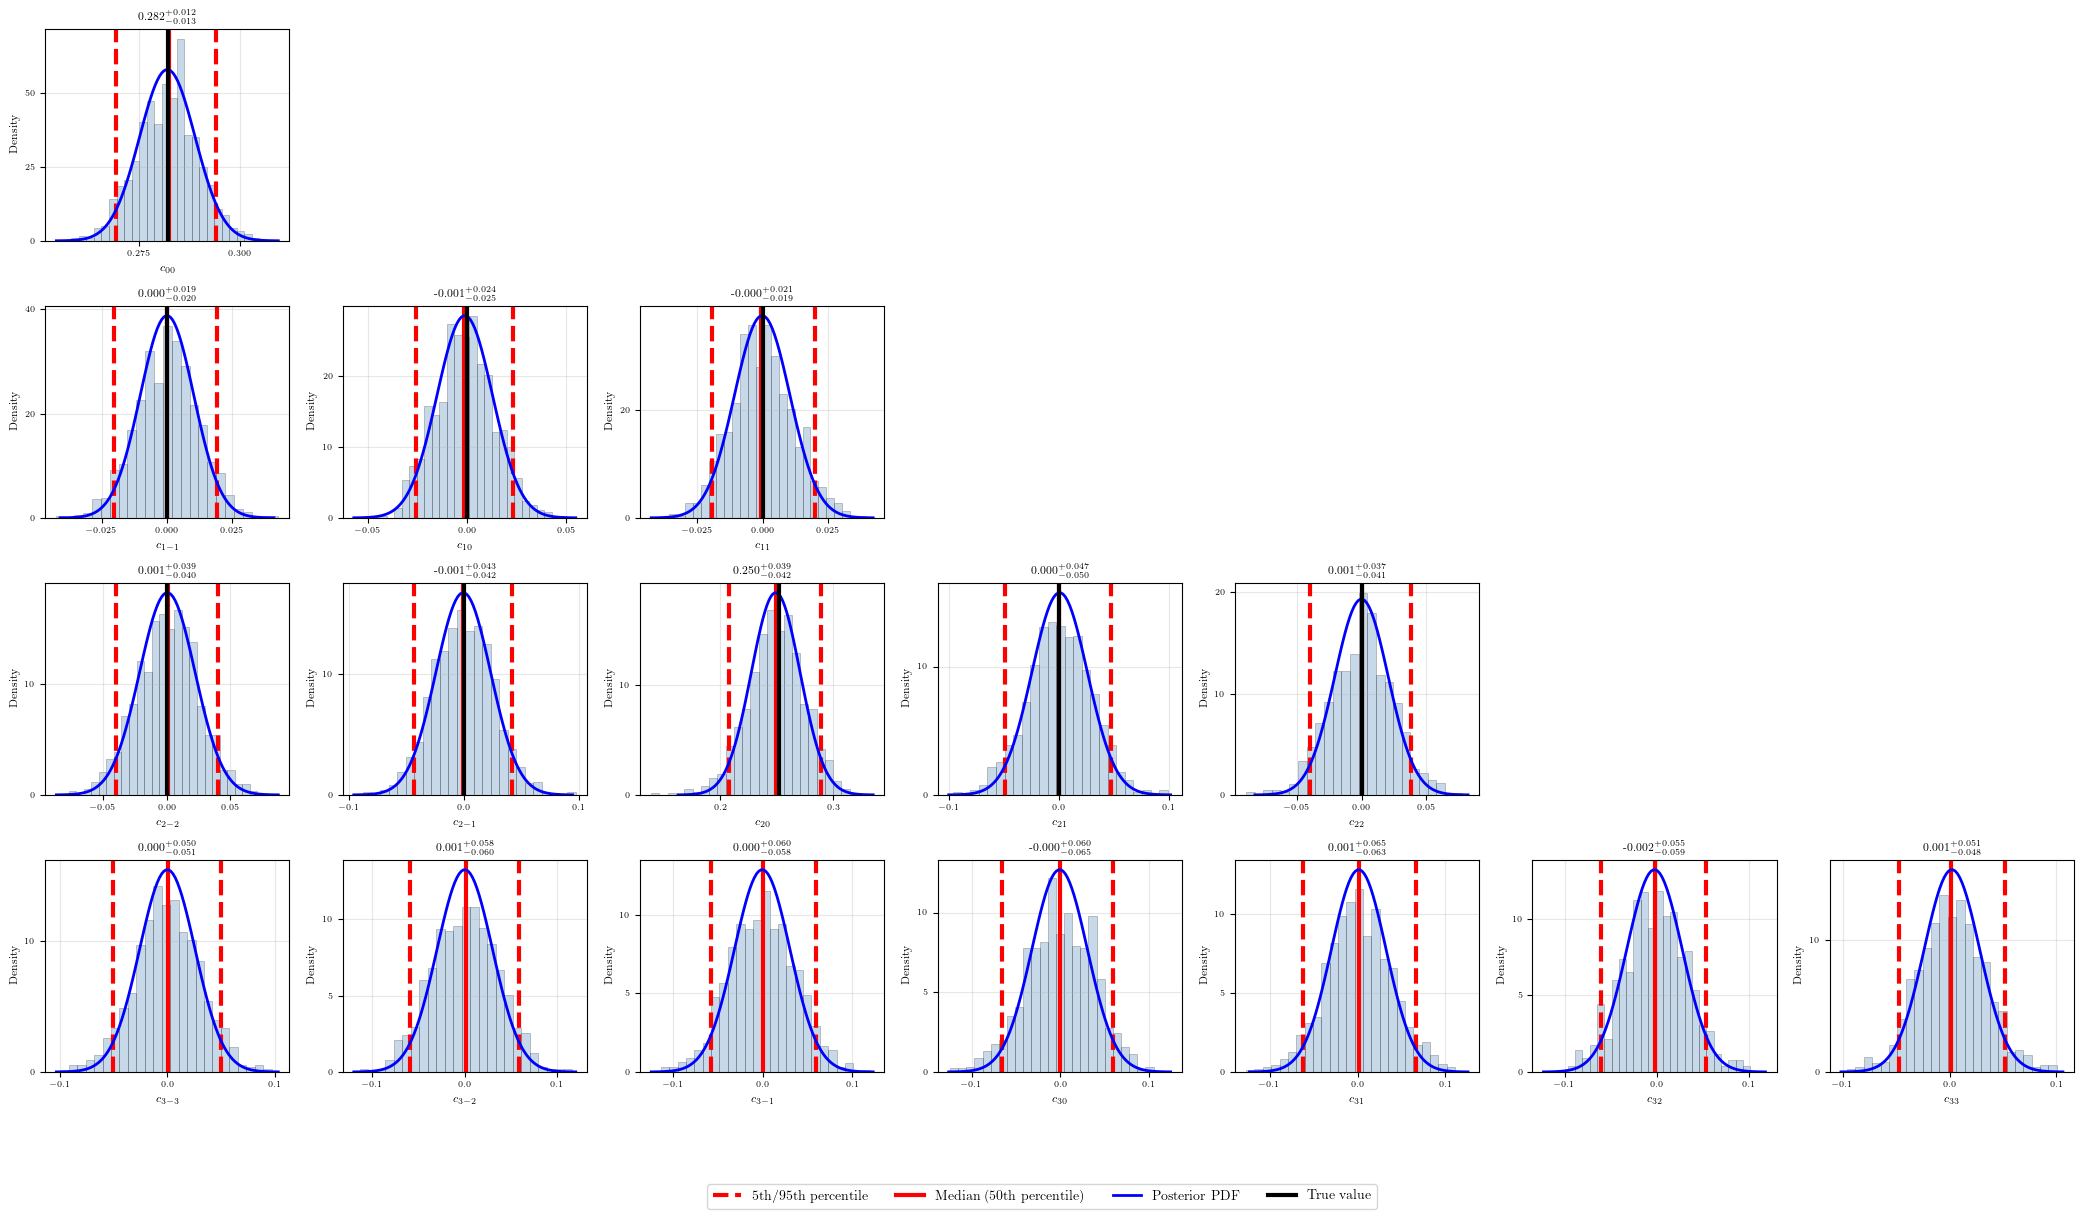

In [6]:
sup.plot_chain_results(
    clms,
    np.mean(clms, axis=0),
    np.mean(dclms, axis=0),
    clms_real,
)

### - Compute and show PP plot

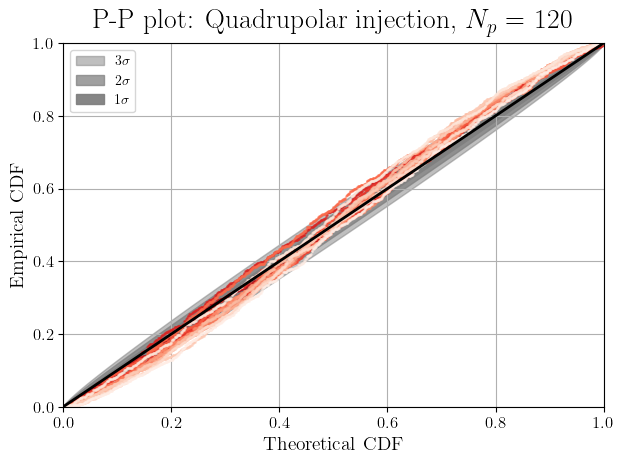

In [7]:
cdf_values = np.array(cdfs)

# Number of parameters (columns) in the CDF array
n_par = len(cdf_values[0])

# Theoretical CDF values uniformly spaced between 0 and 1
theoretical = np.linspace(0, 1, len(cdf_values))

# Standard error of the empirical CDF for each point, assuming binomial statistics
std_err = np.sqrt(theoretical * (1 - theoretical) / n_realizations)

# Plot 3σ, 2σ, and 1σ confidence bands around the theoretical CDF
plt.fill_between(
    theoretical,
    theoretical - 3 * std_err,
    theoretical + 3 * std_err,
    alpha=0.5,
    color="gray",
    label=r"$3 \sigma$",
)
plt.fill_between(
    theoretical,
    theoretical - 2 * std_err,
    theoretical + 2 * std_err,
    alpha=0.75,
    color="gray",
    label=r"$2 \sigma$",
)
plt.fill_between(
    theoretical,
    theoretical - 1 * std_err,
    theoretical + 1 * std_err,
    alpha=0.95,
    color="gray",
    label=r"$1 \sigma$",
)

# Loop over parameters and plot the sorted empirical CDFs for each
for i in range(n_par):
    empirical = np.sort(cdf_values[:, i])  # Sort empirical values for P-P plot
    plt.plot(
        theoretical,
        empirical,
        "o",
        markersize=1,
        color=cmap(1 - (0.2 + 0.8 * (i / n_par))),
        alpha=0.5,
    )

# Plot the diagonal line representing perfect agreement
plt.plot([0, 1], [0, 1], linewidth=2, color="black")

# Grid, labels, axes limits, and title
plt.grid(True, alpha=1)
plt.xlabel("Theoretical CDF")
plt.ylabel("Empirical CDF")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title(
    "P-P plot: " + label + ", $N_p$ = " + str(npulsars), fontsize=20, pad=10
)

# Legend and layout
plt.legend(loc="upper left", fontsize=10)
plt.tight_layout()

# Save figure to file
plt.savefig("plots/PP_plot_" + label + "_" + str(npulsars) + ".pdf", dpi=300)